# Importing the required modules

In [73]:
# Modules used for data handling and manipulation
import numpy as np
import pandas as pd
import json

# Modules used for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

# Modules used for preprocessing
from sklearn.preprocessing import StandardScaler

# Modules used for time series forecasting
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

# Modules used for model evaluation
from sklearn.metrics import mean_absolute_percentage_error
import model

# Modules used for preprocessing
from datetime import datetime, timedelta
import preprocess
from model import Model

# Modules used for object oriented programming
from abc import ABC, abstractmethod

# Modules for suppressing warnings
import warnings 
warnings.filterwarnings('ignore')
import logging
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True

# Consolidating the data

In [2]:
electricity = preprocess.preprocess_modelling(as_numpy=False, clustered=True, stationary=False)
temperature = preprocess.preprocess("temperature")
precipitation = preprocess.preprocess("precipitation")

In [3]:
electricity = electricity.drop(pd.to_datetime("2015-01-01"))

In [4]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

In [5]:
weather = temperature.set_index("date")

# SARIMAX

In [62]:
# class for SARIMAX model
class SARIMAX_model(Model):
    
    def __init__(self, data, exogs, cluster: str, window_stride = 28):
        """
         The constructor for the abstract class Model for standardize evaluation

         Args:
            data: the actual time series that needs to be predicted.
            exogs: the exogeneous variables particularly for SARIMAX.
            cluster: the cluster data which needs to be used (cluster_1 or cluster_0).
            window_stride: the stride (in days) for moving the train-test window; defaults to 28 days.

         Returns:
            - An object of abstract class SARIMA.
        """
        super().__init__(data, cluster, window_stride)
        self.exogs = exogs
    
    # trains the model
    def train_model(self, train, train_idx):
        model = SARIMAX(endog = train[self.cluster], 
                        exog = self.exogs[train_idx[0]: train_idx[1]], 
                        order = (1, 1, 1), 
                        seasonal_order = (1, 1, 0, 12))
        return model.fit()
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(start = self.data.index[test_idx[0]], 
                                        end = self.data.index[test_idx[0]] + timedelta(len(test) - 1),
                                        exog = self.exogs[test_idx[0]: test_idx[1]])

In [63]:
m = SARIMAX_model(electricity, weather, "cluster_1")

In [64]:
m.cross_validate()

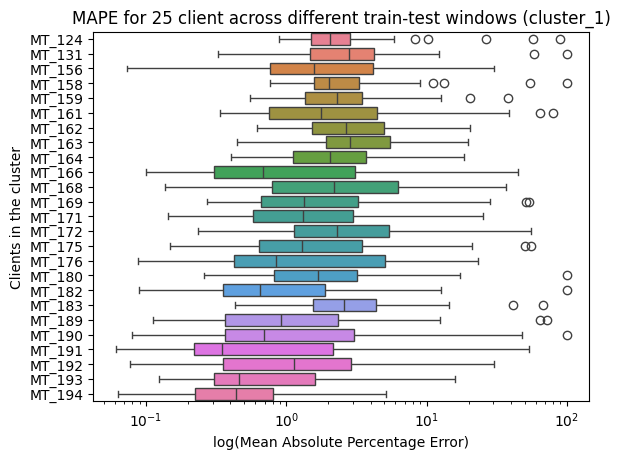

In [65]:
m.mape_boxplot_by_client(25)

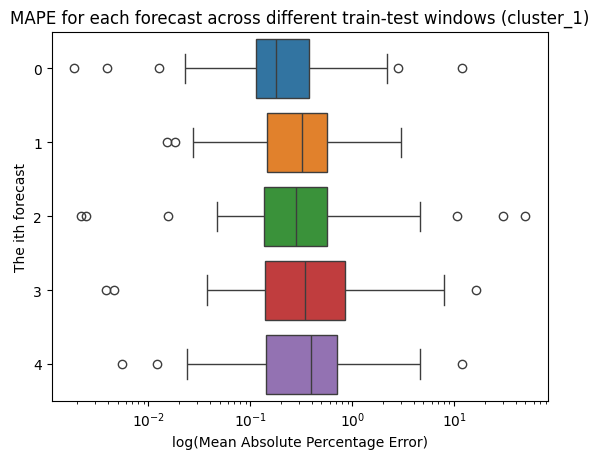

In [125]:
m.mape_boxplot_by_step()

In [126]:
m = SARIMAX_model(electricity, weather, "cluster_0")

In [127]:
m.cross_validate()

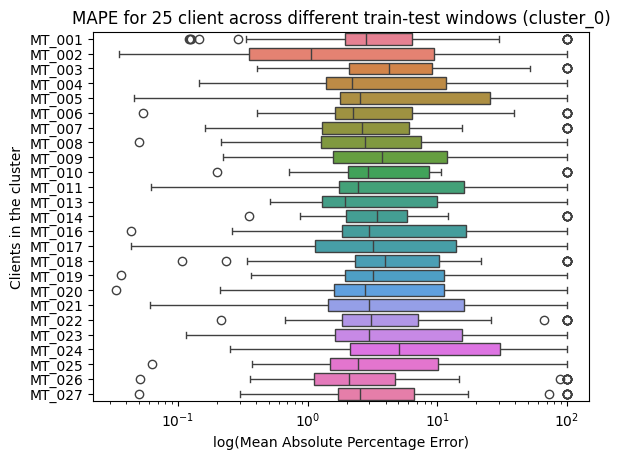

In [128]:
m.mape_boxplot_by_client(25)

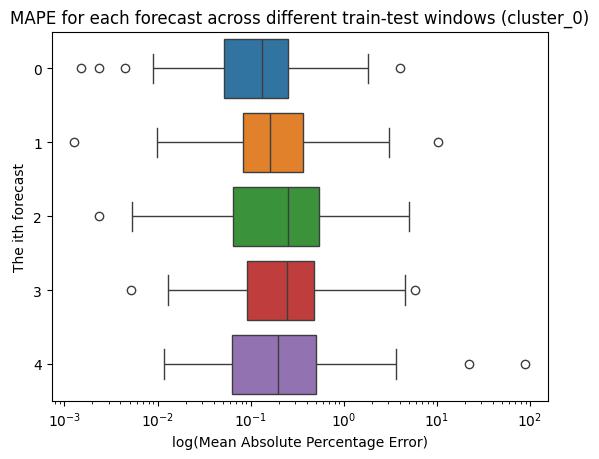

In [129]:
m.mape_boxplot_by_step()

# Facebook Prophet

IMPORTANT: Before running this section, ensure that Facebook Prophet is installed on a virtual environment (_other than_ base).

In [8]:
size = [181, 152]
cluster_0_norm = (electricity["cluster_0"]/(4 * size[0]))
cluster_1_norm = (electricity["cluster_1"]/(4 * size[1]))
temperature['date'] = pd.to_datetime(temperature['date'])
precipitation['date'] = pd.to_datetime(precipitation['date'])

In [9]:
# For cluster 0, only consider readings after 2012
cluster_0_norm_reduced = cluster_0_norm.loc[datetime.strptime('2012-01-01', '%Y-%m-%d').date():]

In [10]:
# Reset index, rename columns
cluster_0_norm_final = cluster_0_norm_reduced.reset_index().rename(columns={"date": "ds", "cluster_0": "y"})
cluster_0_norm_final['ds'] = pd.to_datetime(cluster_0_norm_final['ds'])

cluster_0_norm_merged = cluster_0_norm_final.merge(temperature, left_on='ds', right_on='date').merge(precipitation, left_on='ds', right_on='date')

cluster_0_train = cluster_0_norm_merged.iloc[0:731,:]
cluster_0_test = cluster_0_norm_merged.iloc[731:,:]

In [11]:
fb_prophet = Prophet()
fb_prophet.add_regressor('tmin')
fb_prophet.add_regressor('tmax')
fb_prophet.add_regressor('precip')
fb_prophet.fit(cluster_0_train)

19:05:52 - cmdstanpy - INFO - Chain [1] start processing
19:05:53 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
forecast = fb_prophet.predict(cluster_0_norm_merged)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2012-01-01,13617.857962,10089.278396,11833.020221,13617.857962,13617.857962,-2638.576663,-2638.576663,-2638.576663,-1036.188432,...,-171.167834,-171.167834,-171.167834,-1431.220397,-1431.220397,-1431.220397,0.0,0.0,0.0,10979.281299
1,2012-01-02,13620.207064,10173.513727,11916.379313,13620.207064,13620.207064,-2575.699166,-2575.699166,-2575.699166,-1088.293492,...,-71.544689,-71.544689,-71.544689,-1415.860985,-1415.860985,-1415.860985,0.0,0.0,0.0,11044.507898
2,2012-01-03,13622.556165,10034.096871,11719.020780,13622.556165,13622.556165,-2780.602029,-2780.602029,-2780.602029,-1367.461587,...,-16.981631,-16.981631,-16.981631,-1396.158811,-1396.158811,-1396.158811,0.0,0.0,0.0,10841.954137
3,2012-01-04,13624.905266,9775.187920,11519.235876,13624.905266,13624.905266,-2980.388459,-2980.388459,-2980.388459,-1620.356098,...,12.922665,12.922665,12.922665,-1372.955026,-1372.955026,-1372.955026,0.0,0.0,0.0,10644.516808
4,2012-01-05,13627.254368,10538.928590,12319.927777,13627.254368,13627.254368,-2198.753294,-2198.753294,-2198.753294,-955.773768,...,104.169984,104.169984,104.169984,-1347.149510,-1347.149510,-1347.149510,0.0,0.0,0.0,11428.501074


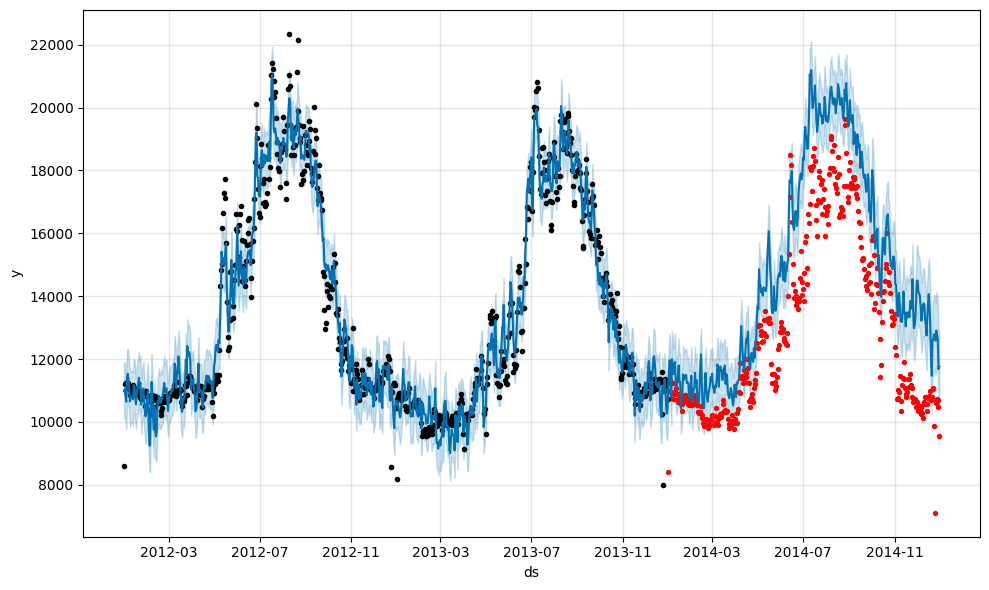

In [13]:
fig = fb_prophet.plot(forecast)
plt.scatter(cluster_0_test['ds'], cluster_0_test['y'], s=8, c='r')

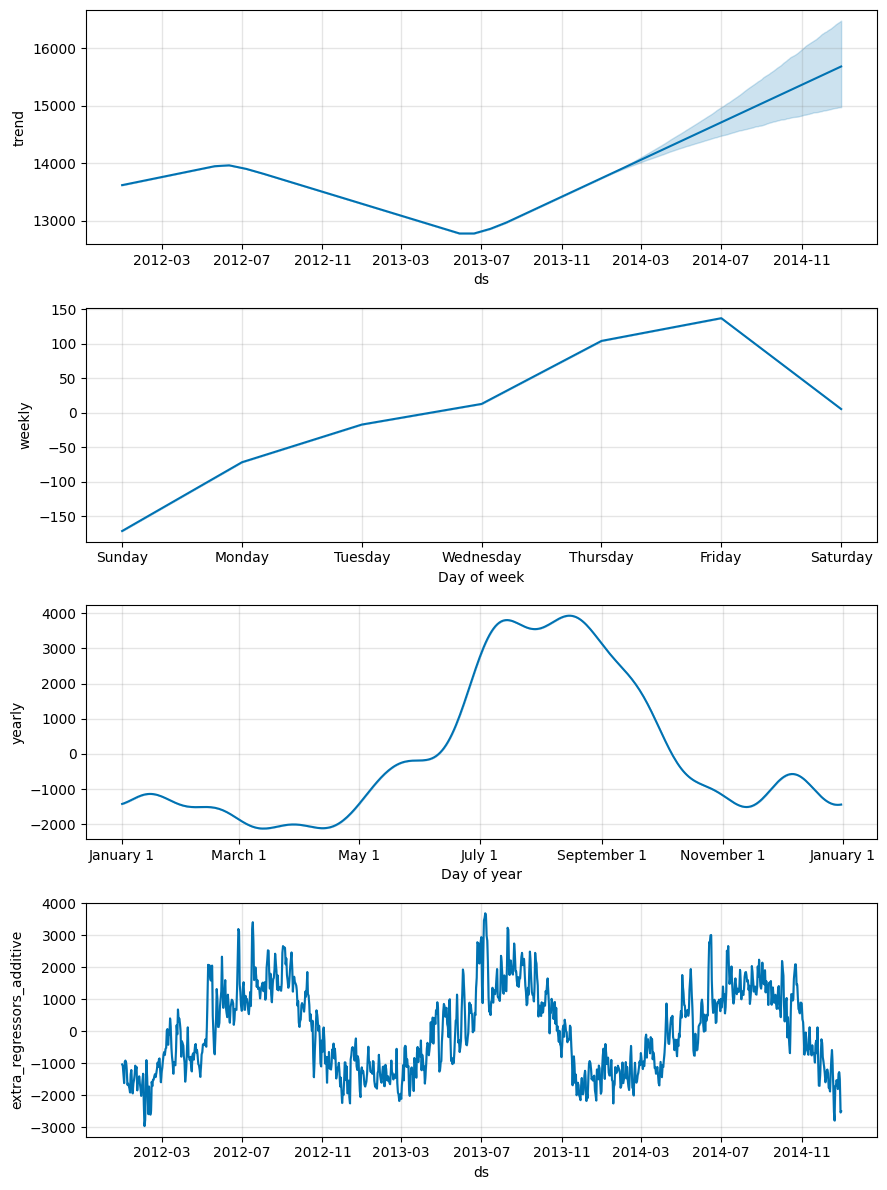

In [14]:
fb_prophet.plot_components(forecast);

In [16]:
# Reset index, rename columns
cluster_1_norm_final = cluster_1_norm.reset_index().rename(columns={"date": "ds", "cluster_1": "y"})
cluster_1_norm_final['ds'] = pd.to_datetime(cluster_1_norm_final['ds'])

cluster_1_norm_merged = cluster_1_norm_final.merge(temperature, left_on='ds', right_on='date').merge(precipitation, left_on='ds', right_on='date')

cluster_1_train = cluster_1_norm_merged.iloc[0:731,:]
cluster_1_test = cluster_1_norm_merged.iloc[731:,:]

In [17]:
fb_prophet = Prophet()
fb_prophet.add_regressor('tmin')
fb_prophet.add_regressor('tmax')
fb_prophet.add_regressor('precip')
fb_prophet.fit(cluster_1_train)

19:06:25 - cmdstanpy - INFO - Chain [1] start processing
19:06:25 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
forecast = fb_prophet.predict(cluster_1_norm_merged)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,extra_regressors_additive,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2011-01-01,19352.797482,17550.206222,19209.809386,19352.797482,19352.797482,-972.427679,-972.427679,-972.427679,-522.197486,...,248.273069,248.273069,248.273069,-698.503262,-698.503262,-698.503262,0.0,0.0,0.0,18380.369803
1,2011-01-02,19355.798378,16544.175026,18264.805783,19355.798378,19355.798378,-1970.931118,-1970.931118,-1970.931118,-872.933405,...,-408.583604,-408.583604,-408.583604,-689.414109,-689.414109,-689.414109,0.0,0.0,0.0,17384.867260
2,2011-01-03,19358.799274,16337.336628,18013.998625,19358.799274,19358.799274,-2146.133063,-2146.133063,-2146.133063,-1385.573167,...,-87.823838,-87.823838,-87.823838,-672.736058,-672.736058,-672.736058,0.0,0.0,0.0,17212.666211
3,2011-01-04,19361.800170,16685.963799,18291.304068,19361.800170,19361.800170,-1901.767292,-1901.767292,-1901.767292,-1297.708483,...,44.674271,44.674271,44.674271,-648.733080,-648.733080,-648.733080,0.0,0.0,0.0,17460.032878
4,2011-01-05,19364.801066,17049.161718,18765.352085,19364.801066,19364.801066,-1496.749112,-1496.749112,-1496.749112,-838.173154,...,-40.761018,-40.761018,-40.761018,-617.814940,-617.814940,-617.814940,0.0,0.0,0.0,17868.051953


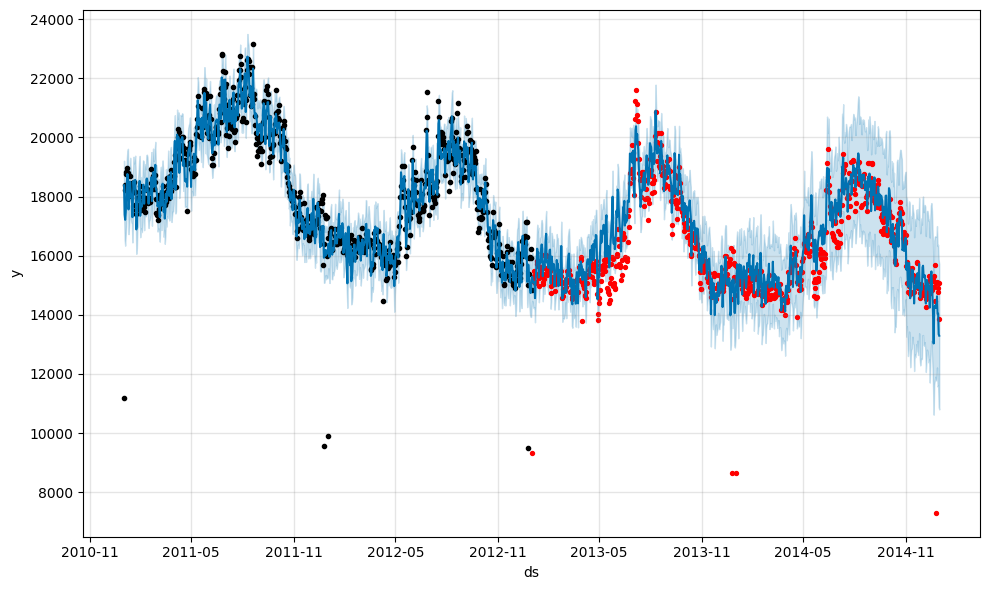

In [19]:
fig = fb_prophet.plot(forecast)
plt.scatter(cluster_1_test['ds'], cluster_1_test['y'], s=8, c='r')

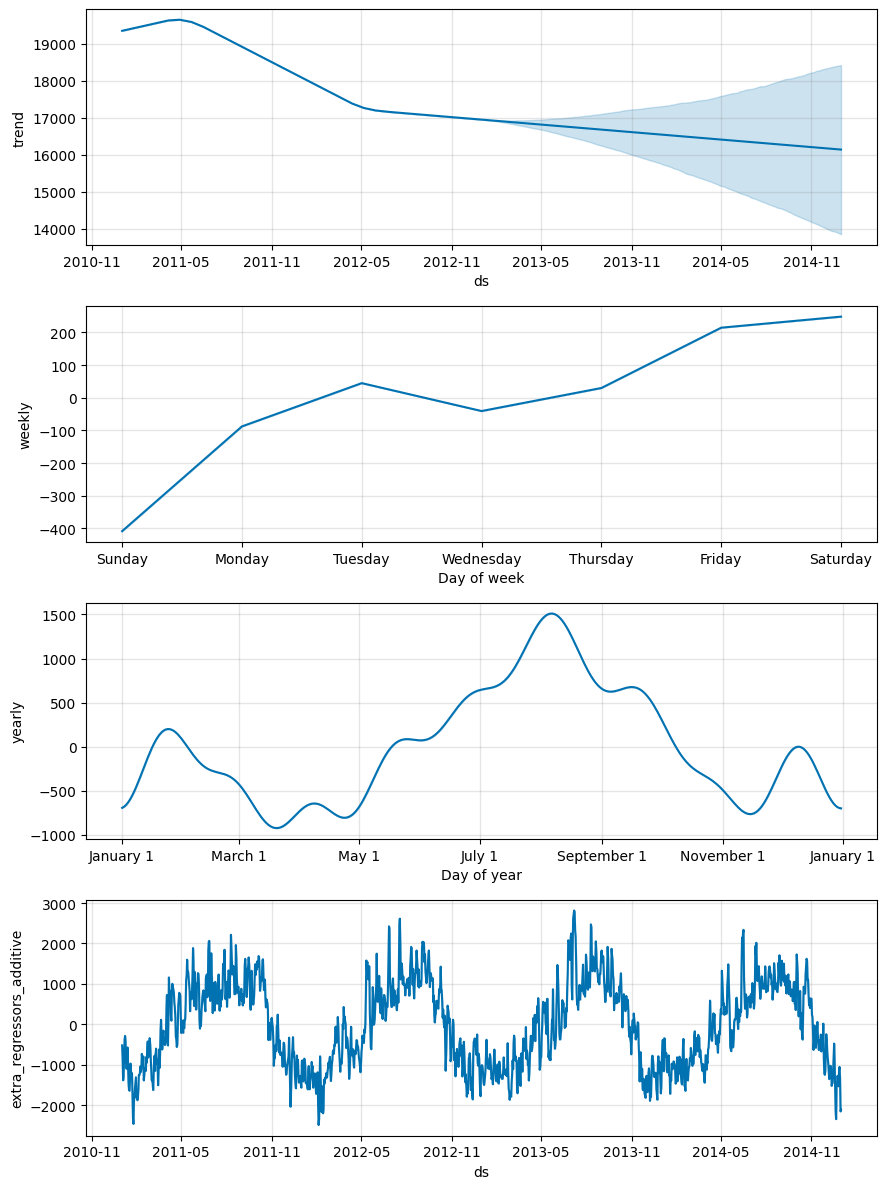

In [20]:
fb_prophet.plot_components(forecast);

In [92]:
# class for Facebook Prophet model
class FacebookProphetModel(Model):
    
    def __init__(self, data, exogs, cluster: str, window_stride = 28):
        super().__init__(data, cluster, window_stride)
        self.data = self.data.reset_index()
        self.data['date'] = pd.to_datetime(self.data['date'])
        self.data = self.data.set_index('date')
        self.exogs = exogs
        
        # Data formatted to match the expected input of Facebook Prophet
        self.data_temp = self.data.reset_index().rename(columns={"date": "ds", self.cluster: "y"}).merge(self.exogs, left_on='ds', right_on='date')
    
    # trains the model
    def train_model(self, train, train_idx):
        model = Prophet()
        for col in self.exogs.columns:
            model.add_regressor(col)
        return model.fit(self.data_temp.iloc[train_idx[0]:train_idx[1],:])
    
    # obtains the forecasts for next five time steps
    def get_forecasts(self, test, test_idx):
        return self.trained_model.predict(self.data_temp.iloc[test_idx[0]:test_idx[1],:])[['ds', 'yhat']].set_index('ds')['yhat']

In [93]:
weather = pd.merge(temperature, precipitation, on='date', how='inner').set_index("date")

In [94]:
m = FacebookProphetModel(electricity, weather, "cluster_1")

In [95]:
m.cross_validate()

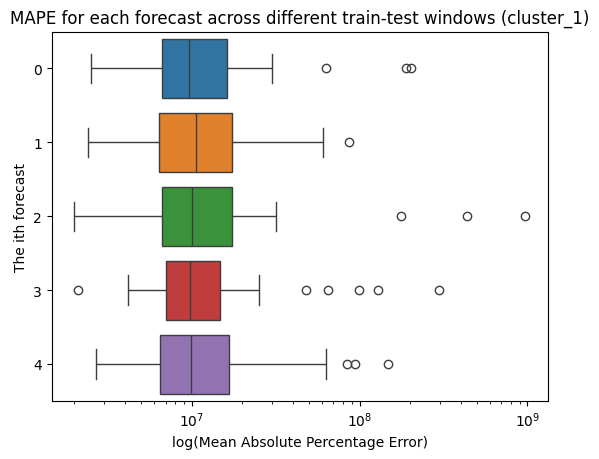

In [96]:
m.mape_boxplot_by_step()

In [98]:
m = FacebookProphetModel(electricity, weather, "cluster_0")

In [99]:
m.cross_validate()

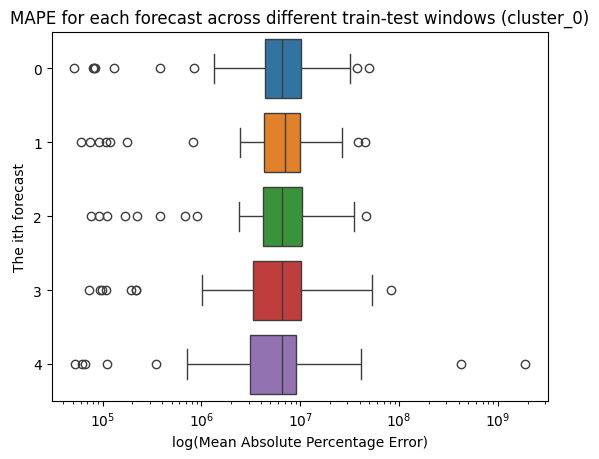

In [100]:
m.mape_boxplot_by_step()